In [163]:
# Import statements

# Data Processing
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, f1_score
from sklearn.metrics import roc_curve, precision_recall_curve  
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV

## 3.1. Logistic Regression <a id="logistic-regression"></a>
[Back to top](#top)

- Import preprocessed features as DataFrames and target variables as Series

In [2]:
# training and test sets with original data distribution

X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv', squeeze=True)

X_test = pd.read_csv('data/X_test.csv')
y_test = pd.read_csv('data/y_test.csv', squeeze=True)

In [3]:
# resampled / balanced training sets

X_train_rus = pd.read_csv('data/X_train_rus.csv')
y_train_rus = pd.read_csv('data/y_train_rus.csv', squeeze=True)

X_train_ros = pd.read_csv('data/X_train_ros.csv')
y_train_ros = pd.read_csv('data/y_train_ros.csv', squeeze=True)

X_train_smote = pd.read_csv('data/X_train_smote.csv')
y_train_smote = pd.read_csv('data/y_train_smote.csv', squeeze=True)

### 3.1.1 Initial Model Building and Evaluation <a id="logistic-regression-initial"></a>
[Back to top](#top)

#### Model Building

- First logistic regression model: We set the maximal number of iterations to ``max_iter=1000`` which allows the solver to converge. Apart from that we use the default hyperparameter values.

In [83]:
# Create pipeline
clf = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=1000, random_state=42))

# Scale and fit model on training data
%time clf.fit(X_train, y_train)

Wall time: 9.8 s


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [5]:
# Predict labels
y_pred = clf.predict(X_test)

In [6]:
clf.score(X_test, y_test)

0.9118568232662192

Our first impression is a good accuracy of 91%. However, having the data imbalance in mind, we will evaluate the model in detail.

#### Model Evaluation 

Count of 0 in test set: 16307, (91.2025%)
Count of 1 in test set: 1573, (8.7975%)


C:\Users\fabio\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='readmitted_within_30_days', ylabel='count'>

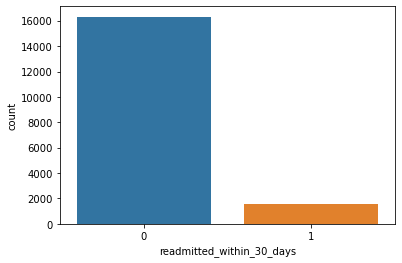

In [7]:
count_0 = (y_test == 0).sum()
count_1 = (y_test == 1).sum()

print(f'Count of 0 in test set: {count_0}, ({round(count_0 / len(y_test) * 100, 4)}%)')
print(f'Count of 1 in test set: {count_1}, ({round(count_1 / len(y_test) * 100, 4)}%)')

sns.countplot(y_test)

The '0' class has a share of 91.2% of all target values in the test data. This means a simple estimator which is always predicting 0 will have an accuracy of 91.2% while evaluated on this data set.

In [8]:
# Classifier which is always predicting the majority class label

simplest_clf = DummyClassifier()
simplest_clf.fit(X_train, y_train)
simplest_clf.score(X_test, y_test)

0.9120246085011185

Consequently, our trained logistic regression model does not have a satisfying accuracy since it is in fact less accurate than the simplest model imaginable!

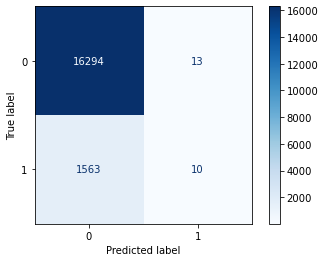

In [9]:
# scikit-learn 1.0 needed

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

In the confusion matrix, the data imbalance becomes obvious. The majority of the instances in the test dataset is classified correctly ($\rightarrow$ therefore the 'good' accuracy), the large majority in the 'True Negative' section. Out of the 17,880 instances, the classifier predicted only 23 instances as '1', and only 10 of these predictions were correct. As we are interested in a model which identifies patients which will be readmitted to the hospital, this model is as worse as it can get. This becomes even clearer if we normalize the counts display in the confusion matrix over the true conditions:

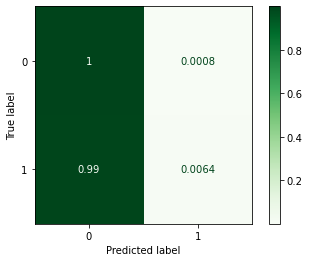

In [10]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Greens', normalize='true')

While only 0.0008% of all '0' instances are misclassified as '1', 99% of all '1' instances are misclassified as '0'!

In [11]:
# Print evaluation metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     16307
           1       0.43      0.01      0.01      1573

    accuracy                           0.91     17880
   macro avg       0.67      0.50      0.48     17880
weighted avg       0.87      0.91      0.87     17880



The classification report summarized the already observed difference in performance with respect to the different target classes. We have an overall good accuracy because the classifier performs well in regard to the majority class where it shows perfect recall while also giving a good precision. In regard to the minority class in which we are particularly interested in, the classifier shows an abysmal performance, having the worst possible recall while not even having a good precision.

### 3.1.3. Hyperparameter Tuning to improve Accuracy <a id="logistic-regression-accuracy"></a>
[Back to top](#top)

In [12]:
# Show hyperparameters and their values
clf['logisticregression'].get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Hyperparameters to be varied:

- ``penalty``: By default, a l2 regularization is performed. Alternatively, the logistic regression can be done without any regularization or the penalty term can be changed to l1 norm or an elastic net. We opt for an elastic net which includes l1 and l2 regularization (see ``l1_ratio``).

- ``l1_ratio``: The combination of l1 and l2 penalty in the elastic net can be selected by a ratio between 0 and 1. A value of 0 equals l2 regularization while the value of 1 equals l1 regularization.

- ``C``: Inverse of regularization strength. A lower value results in a stronger regularization with 1.0 being the default.

- ``solver``: The algorithm which solves the optimization problem. For the search, we opt for the 'saga' solver, a stochastic average gradient descent implementation which supports elastic net regularization and is recommended for large datasets (https://scikit-learn.org/dev/modules/linear_model.html#logistic-regression).

- ``fit_intercept``: Specification if an intercept should be added to the regression function

- ``max_iter``: Maximum number of iterations as limit for the solver to converge.

- ``tol``: Tolerance of the stopping criteria, by default: 0.0001.

- ``warm_start``: When set to True, the solution of the previous call is used to fit as initialization (False by default.

- ``class_weight``: Weights associated with the different classes in the target variable. By default, all classes are weighted the same. Apart from manually assigning weights to each class, we can use the 'balanced' option which automatically adjust weights inversely proportional to class frequencies. We will deal with class imbalances later.

In the following section, we try to optimize the logistic regression model with regard to its accuracy score. As discussed in the previous section, accuracy might not be the best evaluation metric for our problem. However, an improvement of the accuracy could potentially improve the model: Since the recall for class 0 is already almost 100%, a siginificant increase in accuracy can only be obtained if the classification performance for class 1 improves.


We start by having a detailed look at the hyperparameters of scikit-learn's implementation in order to decide how to vary the model. We conduct a randomized search on a large parameter grid before finetuning with a grid search on a narrowly defined grid.

After having a detailed look at the possible hyperparameter values, we create the following parameter grid which will be given to the randomized search algorithm:

In [13]:
param_dist = {'logisticregression__solver': ['saga'],
              'logisticregression__penalty': ['elasticnet', 'none'],
              'logisticregression__l1_ratio': np.linspace(0, 1, 11), # try different elastic nets
              'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], # vary regularization strength
              'logisticregression__fit_intercept': [False, True], 
              'logisticregression__tol': [0.000001, 0.00001, 0.0001, 0.001, 0.01], # vary stopping threshold
              'logisticregression__warm_start': [False, True],         
             }

We conduct a 5-fold cross validated search where 10 randomly selected parameter combinations are tried:

In [14]:
random_search = RandomizedSearchCV(estimator=clf, 
                                   param_distributions = param_dist,
                                   n_jobs=-1,
                                   cv=3, #reduced to 3-fold to reduce runtime
                                   verbose=1)
%time random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Wall time: 8min 2s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=500,
                                                                 random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'logisticregression__C': [0.001, 0.01,
                                                                  0.1, 1, 10,
                                                                  100, 1000,
                                                                  10000],
                                        'logisticregression__fit_intercept': [False,
                                                                              True],
                                        'logisticregression__l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                   

Look a the results of the different tried estimators and identify the best one

In [15]:
rs_cv_results = pd.DataFrame(random_search.cv_results_)
rs_cv_results.sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__warm_start,param_logisticregression__tol,param_logisticregression__solver,param_logisticregression__penalty,param_logisticregression__l1_ratio,param_logisticregression__fit_intercept,param_logisticregression__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,4.559882,0.282111,0.050712,0.000042,False,0.000001,saga,elasticnet,0.3,True,0.001,"{'logisticregression__warm_start': False, 'log...",0.911969,0.912020,0.912020,0.912003,0.000024,1
8,12.114837,1.543198,0.060111,0.008308,True,0.001,saga,elasticnet,0.1,False,1,"{'logisticregression__warm_start': True, 'logi...",0.911857,0.911964,0.911684,0.911835,0.000115,2
1,76.275493,0.316831,0.054079,0.004847,False,0.000001,saga,none,0.6,True,100,"{'logisticregression__warm_start': False, 'log...",0.911689,0.911908,0.911349,0.911648,0.000230,3
0,36.814502,4.362046,0.060860,0.000056,False,0.001,saga,none,1.0,False,10,"{'logisticregression__warm_start': False, 'log...",0.911633,0.911852,0.911349,0.911611,0.000206,4
2,52.326456,7.244754,0.045311,0.003908,False,0.001,saga,elasticnet,1.0,False,100,"{'logisticregression__warm_start': False, 'log...",0.911633,0.911852,0.911349,0.911611,0.000206,4
3,123.713347,1.473037,0.050756,0.000049,True,0.0001,saga,elasticnet,0.7,False,10000,"{'logisticregression__warm_start': True, 'logi...",0.911577,0.911852,0.911349,0.911593,0.000206,6
4,78.936034,0.928515,0.051346,0.000983,True,0.00001,saga,none,0.0,False,0.01,"{'logisticregression__warm_start': True, 'logi...",0.911577,0.911852,0.911349,0.911593,0.000206,6
5,79.544176,0.579456,0.050737,0.000071,True,0.0001,saga,none,1.0,False,1,"{'logisticregression__warm_start': True, 'logi...",0.911577,0.911852,0.911349,0.911593,0.000206,6
6,79.831003,1.437049,0.073884,0.027130,True,0.0001,saga,none,0.6,False,1000,"{'logisticregression__warm_start': True, 'logi...",0.911577,0.911852,0.911349,0.911593,0.000206,6
9,68.721903,0.868092,0.040193,0.007143,True,0.0001,saga,none,0.8,False,10,"{'logisticregression__warm_start': True, 'logi...",0.911577,0.911852,0.911349,0.911593,0.000206,6


In [16]:
random_search.best_params_

{'logisticregression__warm_start': False,
 'logisticregression__tol': 1e-06,
 'logisticregression__solver': 'saga',
 'logisticregression__penalty': 'elasticnet',
 'logisticregression__l1_ratio': 0.30000000000000004,
 'logisticregression__fit_intercept': True,
 'logisticregression__C': 0.001}

In [17]:
clf_opt = random_search.best_estimator_

In [18]:
random_search.best_estimator_.score(X_test, y_test)

0.9120246085011185

#### 'Optimized' Model Evaluation

However, the search did not result in a model with a significantly improved accuracy.

In [19]:
# Predict labels
y_pred = clf_opt.predict(X_test)

# Print metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     16307
           1       0.00      0.00      0.00      1573

    accuracy                           0.91     17880
   macro avg       0.46      0.50      0.48     17880
weighted avg       0.83      0.91      0.87     17880



C:\Users\fabio\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fabio\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fabio\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


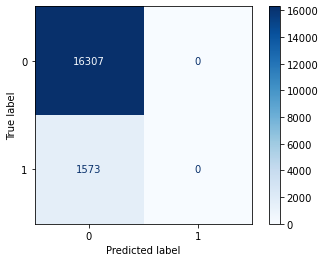

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

In fact, we found a model which is always predicting 0!

### 3.1.4. Weighted Logistic Regression to improve ROC-AUC <a id="weighted-logistic-regression"></a>
[Back to top](#top)

In the following section we want to develop a class-weighted logistic regression model to handle the substantial data imbalance better. As accuracy is not a suitable metric (see initial model evaluation), we optimize it in respect to the ROC-AUC metric which describes the area under the receiver operating characteristic (ROC) curve. The ROC curve illustrates the performance of a classifier in terms of true positive rate (recall) and false positive rate as its dicrimination threshold is varied.

#### Starting point

Since the search in the previous section did not result in a better model, we start with our initial logistic regression model again. First, we calculate the ROC-AUC metric and plot the ROC curve of our basic classifier.

In [94]:
# calculate prediction probabilities
y_prob = clf.predict_proba(X_test)

# calculate roc-auc
roc_auc_score(y_test, y_prob[:,1])

0.6507265570411904

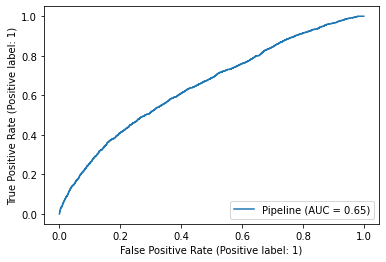

In [95]:
# plot roc curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)

While the ROC curve is far from having a satisfying shape, it is slightly above the bisector. This is reflected in a AUC of 0.65.

#### Weighted Logistic Regression using built-in 'balanced' mode

The scikit-learn implementation provides the 'balanced' mode which uses the following formula to calculate the class weights: ``n_samples / (n_classes * np.bincount(y))``. Hence the following weights are automatically assigned for our training set:

In [238]:
print(f'Class weights in "balanced" mode: {y_train.shape[0] / (y_train.nunique() * np.bincount(y_train))}')

Class weights in "balanced" mode: [0.548244   5.68199153]


This means that the instances of the minority class are weighted around ten times more within the model than the instances of the majority class. This reflects the fact that the majority class has about 10 times more instances than the minority class in the dataset.

In [239]:
# define model
clf_balanced = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))

In [250]:
# fit model
%time clf_balanced.fit(X_train, y_train)

Wall time: 14.5 s


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [251]:
# calculate probability estimates
y_prob = clf_balanced.predict_proba(X_test)
y_prob_1 = y_prob[:,1]

# calculate roc-auc
roc_auc_score(y_test, y_prob_1)

0.6514416973338686

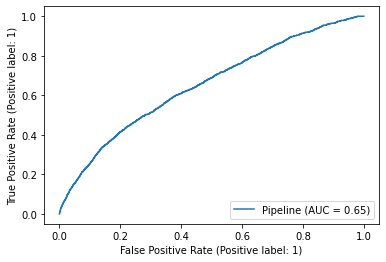

In [48]:
# plot roc curve
RocCurveDisplay.from_estimator(clf_balanced, X_test, y_test)

We observe a small improvement in the ROC-AUC metric using the inverse ratio of the training data (the 'balanced' mode). However, this is a heuristic which does not necessarily yield the best results out of all class weight combinations (https://machinelearningmastery.com/cost-sensitive-logistic-regression/). We conduct a grid search which brute forces different weights in order to either confirm the assumption that the 'balanced' weighting yields the best results or to further improve our ROC-AUC metric.

In [98]:
# create parameter grid with different weight ratios
weight_grid = {'logisticregression__class_weight': [{0: 1, 1: 1}, 
                                                    {0: 1, 1: 10}, 
                                                    {0: 1, 1: 100},
                                                    {0: 1, 1: 1000},
                                                    'balanced']}

In [241]:
# initialize grid search with roc-auc as score
weight_search_roc = GridSearchCV(clf, param_grid=weight_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)

# fit on training data
%time weight_search_roc.fit(X_train, y_train)

In [87]:
ws_roc_cv_results = pd.DataFrame(weight_search.cv_results_)

ws_roc_cv_results.loc[:, ['param_logisticregression__class_weight', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)

,param_logisticregression__class_weight,mean_test_score
5,balanced,0.645640
2,"{0: 1, 1: 10}",0.645496
1,"{0: 1, 1: 1}",0.644422
3,"{0: 1, 1: 100}",0.644043
4,"{0: 1, 1: 1000}",0.643280
0,"{0: 1, 1: 0.1}",0.641992


The best cross-validated ROC-AUC scores are in fact obtained by the balancing heuristic (which we already evaluated above). It is not better to weight the minority class even more (or less).

#### Probability Calibration

Like many other classifiers, a logistic regression is not directly predicting the classes. Instead, the model is predicting the probability for every instance to be in a certain class. Depending on the set discrimination threshold, the actual classification is calculated in the next step. In a well calibrated model, the predicted probabilities reflect the data distribution.

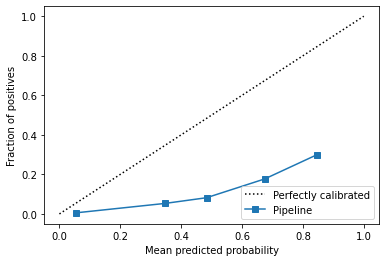

In [233]:
# scikit-learn 1.0 needed
# show calibration curve of current model

CalibrationDisplay.from_estimator(clf_balanced, X_test, y_test)

In general, logistic regression models are by default well calibrated because they are minimizing the log loss. Nevertheless, we fit it again in order to get the best possible calibration. 

In [247]:
# fit and calibrate model on training data

clf_calibrated = CalibratedClassifierCV(clf_balanced, n_jobs=-1)
%time clf_calibrated.fit(X_train, y_train)

Wall time: 50.1 s


CalibratedClassifierCV(base_estimator=Pipeline(steps=[('minmaxscaler',
                                                       MinMaxScaler()),
                                                      ('logisticregression',
                                                       LogisticRegression(class_weight='balanced',
                                                                          max_iter=1000,
                                                                          random_state=42))]),
                       n_jobs=-1)

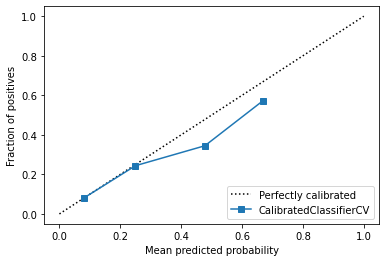

In [248]:
# scikit-learn 1.0 needed
# show calibration curve of calibrated model

CalibrationDisplay.from_estimator(calibrated_model, X_test, y_test)

#### G-Mean Optimizing Threshold Selection

The ROC-AUC metric provides a measure of performance across all possible discrimination thresholds. To have the best possible model we have to choose the threshold which suits the purpose of the model. A common way to choose the threshold is to maximize the geometric mean between the two dimensions of the ROC curve, true positive rate and false positive rate.

In [111]:
# predict probabilities
y_prob = clf_balanced.predict_proba(X_test)

# probabilities for the positive outcome only
y_prob_1 = y_prob[:, 1]

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_1)

# calculate g-mean for every threshold
gmeans = np.sqrt(tpr * (1-fpr))

In [110]:
# Save in dataframe and sort by gmean

df_thresh = pd.DataFrame({'Threshold': thresholds, 'FPR': fpr, 'TPR': tpr, 'GMean': gmeans})
df_thresh.sort_values(by='GMean', ascending=False)

,Threshold,FPR,TPR,GMean
1617,0.484779,0.374686,0.593134,0.609012
1613,0.485987,0.371374,0.589955,0.608984
1611,0.486138,0.370884,0.589320,0.608893
1635,0.482311,0.381615,0.599491,0.608865
1621,0.484019,0.376648,0.594406,0.608707
...,...,...,...,...
4,0.964480,0.000123,0.001907,0.043669
1,0.984316,0.000000,0.000636,0.025214
2,0.974490,0.000061,0.000636,0.025213
0,1.984316,0.000000,0.000000,0.000000


In [113]:
# get the best threshold
best_thresh = thresholds[np.argmax(gmeans)]
best_thresh

0.4847793094556708

#### Weighted Model Evaluation

In [120]:
# calculate probability estimates for class 1
y_prob = clf_balanced.predict_proba(X_test)
y_prob_1 = y_prob[:,1]

#calculate predictions using custom discrimination threshold
y_pred = (y_prob_1 >= best_thresh).astype(int)

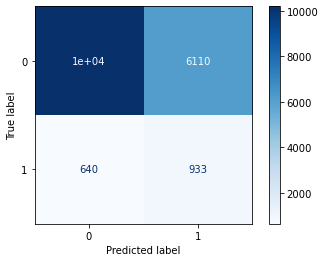

In [122]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

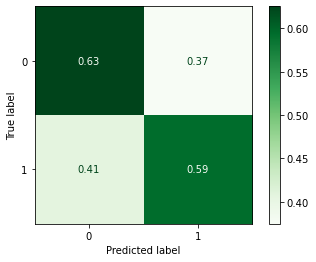

In [124]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', cmap='Greens')

In [121]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.63      0.75     16307
           1       0.13      0.59      0.22      1573

    accuracy                           0.62     17880
   macro avg       0.54      0.61      0.48     17880
weighted avg       0.87      0.62      0.70     17880



From a minority class perspective we improved our model significantly. While the basic logistic regression misclassified almost every minority class instance, the weighted model is classifying 59% correctly (=recall). This happened at the expense of overall accuracy since many majority class instances are now misclassified as well. The trade-off of recall and precision becomes visible: While the recall is substantially improved, precision decreased substantially to 13%. In other words: Out of 8 times the classifier predicts the minority class, only one classification is correct.

### 3.1.5. Precision-Recall Curve <a id="logistic-regression-pr"></a>
[Back to top](#top)

In the previous section we improved our model in respect to the ROC-AUC metric and were able to get a more satisfying model regarding the purpose to identify patients which will get readmitted to the hospital within 30 days. Having that goal in mind, we can state that we are more/particularly interested in the performance regarding the minority class '1' and less interested in the performance regarding the majority class '0'. Therefore, it is worth to look at the precision-recall curve which only takes the class 1 into account. It can be avaluated by calculating the so-called 'average precision' which equals the area under its curve.

#### Starting point

Let's have a look at the PR curve and average precision score of the already built basic and weighted logistic regression models.

In [253]:
y_prob_1 = clf.predict_proba(X_test)[:,1]
average_precision_score(y_test, y_prob_1)

0.11771666360585446

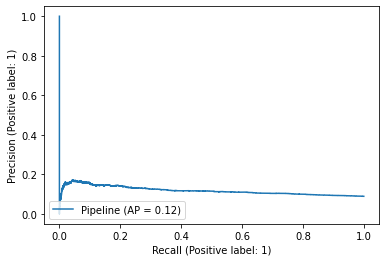

In [254]:
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)

In [255]:
y_prob_1 = clf_balanced.predict_proba(X_test)[:,1]
average_precision_score(y_test, y_prob_1)

0.16783993101817343

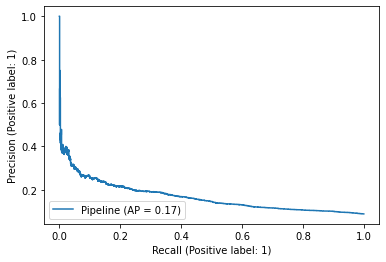

In [256]:
PrecisionRecallDisplay.from_estimator(clf_balanced, X_test, y_test)

We observe two PR curves which are far from an ideal shape. However, the weighted model shows a significantly better average precisions core than the basic classifier.

#### Hyperparameter Tuning 

We conduct a random search similar to the [Hyperparameter Tuning](#logistic-regression-accuracy) before, this time using the average precision as score.

In [258]:
param_dist = {'logisticregression__solver': ['saga'],
              'logisticregression__penalty': ['elasticnet', 'none'],
              'logisticregression__l1_ratio': np.linspace(0, 1, 11), # try different elastic nets
              'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], # vary regularization strength
              'logisticregression__fit_intercept': [False, True], 
              'logisticregression__tol': [0.000001, 0.00001, 0.0001, 0.001, 0.01], # vary stopping threshold
              'logisticregression__warm_start': [False, True],
              'logisticregression__class_weight': ['balanced']
             }

In [140]:
random_search = RandomizedSearchCV(estimator=clf, 
                                   param_distributions = param_dist,
                                   scoring='average_precision',
                                   cv=3, #reduced to 3-fold to reduce runtime
                                   n_jobs=-1,
                                   verbose=1)
%time random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Wall time: 16min


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=1000,
                                                                 random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'logisticregression__C': [0.001, 0.01,
                                                                  0.1, 1, 10,
                                                                  100, 1000,
                                                                  10000],
                                        'logisticregression__class_weight': [None,
                                                                             'balanced'],
                                        'logisticregression__fit_intercept': [False,
                                                                  

In [141]:
rs_cv_results = pd.DataFrame(random_search.cv_results_)
rs_cv_results.sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__warm_start,param_logisticregression__tol,param_logisticregression__solver,param_logisticregression__penalty,param_logisticregression__l1_ratio,param_logisticregression__fit_intercept,param_logisticregression__class_weight,param_logisticregression__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,6.703994,0.587359,0.053335,0.000943,True,0.01,saga,elasticnet,0.2,True,None,10000,"{'logisticregression__warm_start': True, 'logi...",0.175554,0.162100,0.154016,0.163890,0.008884,1
6,5.881994,1.206025,0.051671,0.000473,False,0.01,saga,elasticnet,0.1,False,None,10,"{'logisticregression__warm_start': False, 'log...",0.175567,0.162062,0.153956,0.163862,0.008914,2
1,167.019006,0.620905,0.071332,0.010780,False,0.0001,saga,none,0.1,False,None,0.1,"{'logisticregression__warm_start': False, 'log...",0.172728,0.160613,0.153958,0.162433,0.007770,3
2,162.003766,6.082071,0.057668,0.003858,False,0.00001,saga,none,0.7,False,None,100,"{'logisticregression__warm_start': False, 'log...",0.172728,0.160613,0.153958,0.162433,0.007770,3
9,10.571996,0.586781,0.058668,0.008055,True,0.001,saga,elasticnet,0.1,False,balanced,0.1,"{'logisticregression__warm_start': True, 'logi...",0.172959,0.159204,0.153480,0.161881,0.008174,5
7,9.624663,0.245186,0.052001,0.000816,True,0.000001,saga,elasticnet,0.7,True,balanced,0.01,"{'logisticregression__warm_start': True, 'logi...",0.159252,0.146422,0.145939,0.150538,0.006165,6
0,168.651673,0.126495,0.109010,0.024131,False,0.01,saga,none,0.3,True,balanced,0.01,"{'logisticregression__warm_start': False, 'log...",0.139698,0.148198,0.146532,0.144810,0.003678,7
4,160.979330,1.058560,0.076335,0.018447,True,0.000001,saga,none,1.0,True,balanced,10000,"{'logisticregression__warm_start': True, 'logi...",0.139698,0.148198,0.146532,0.144810,0.003678,7
3,245.151950,0.231626,0.071012,0.016324,True,0.01,saga,elasticnet,0.8,True,balanced,1,"{'logisticregression__warm_start': True, 'logi...",0.143286,0.140829,0.147285,0.143800,0.002661,9
5,243.726329,27.393802,0.057672,0.015280,False,0.00001,saga,elasticnet,0.5,True,balanced,10,"{'logisticregression__warm_start': False, 'log...",0.143758,0.137830,0.137501,0.139697,0.002875,10


In [146]:
random_search.best_params_

{'logisticregression__warm_start': True,
 'logisticregression__tol': 0.01,
 'logisticregression__solver': 'saga',
 'logisticregression__penalty': 'elasticnet',
 'logisticregression__l1_ratio': 0.2,
 'logisticregression__fit_intercept': True,
 'logisticregression__class_weight': None,
 'logisticregression__C': 10000}

In [144]:
# get best model
clf_opt = random_search.best_estimator_

In [260]:
# predict probability estimates
y_prob = clf_opt.predict_proba(X_test)
y_prob_1 = y_prob[:,1]

# predict average precison
average_precision_score(y_test, y_prob_1)

0.16867819561257236

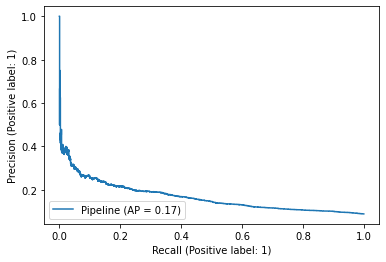

In [227]:
PrecisionRecallDisplay.from_estimator(clf_balanced, X_test, y_test)

We observe a slight improvement in the average precision score.

#### Calibration

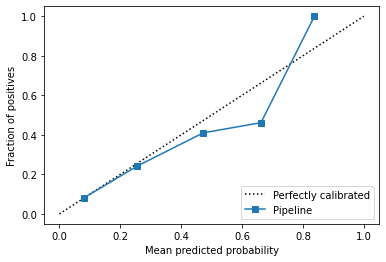

In [264]:
# scikit-learn 1.0 needed
# show calibration curve of current model

CalibrationDisplay.from_estimator(clf_opt, X_test, y_test)

In [263]:
# fit and calibrate model on training data
clf_calibrated = CalibratedClassifierCV(clf_opt, n_jobs=-1)
%time clf_calibrated.fit(X_train, y_train)

Wall time: 17.5 s


CalibratedClassifierCV(base_estimator=Pipeline(steps=[('minmaxscaler',
                                                       MinMaxScaler()),
                                                      ('logisticregression',
                                                       LogisticRegression(C=10000,
                                                                          l1_ratio=0.2,
                                                                          max_iter=1000,
                                                                          penalty='elasticnet',
                                                                          random_state=42,
                                                                          solver='saga',
                                                                          tol=0.01,
                                                                          warm_start=True))]),
                       n_jobs=-1)

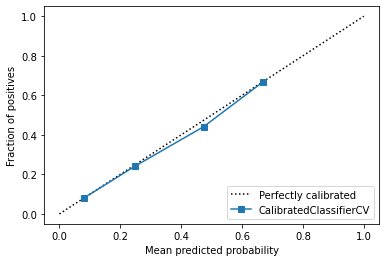

In [265]:
# scikit-learn 1.0 needed
# show calibration curve of calibrated model

CalibrationDisplay.from_estimator(clf_calibrated, X_test, y_test)

In [266]:
print(classification_report(y_test, clf_calibrated.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     16307
           1       0.41      0.00      0.01      1573

    accuracy                           0.91     17880
   macro avg       0.66      0.50      0.48     17880
weighted avg       0.87      0.91      0.87     17880



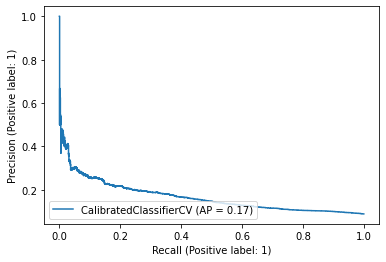

In [267]:
PrecisionRecallDisplay.from_estimator(clf_calibrated, X_test, y_test)

#### F-Score Optimizing Threshold Selection

We can select our preferred discrimiination threshold according to a weighted measure of the two dimensions precision and recall. The most common F-score is the F1 which is used if recall and precision are seen as equally important. We additionally calculate the F2-score for which the recall is twice as important as the precision.

In [272]:
# predict probabilities
y_prob = clf_calibrated.predict_proba(X_test)

# probabilities for the positive outcome only
y_prob_1 = y_prob[:, 1]

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_1)

# calculate f scores for every threshold
f1_scores = (2 * precision * recall) / (precision + recall)
f2_scores = (5 * precision * recall) / (4 * precision + recall)

In [273]:
# Save in dataframe and sort by f1-score
df_thresh_f1 = pd.DataFrame({'Threshold': thresholds, 'Precision': precision[:-1], 'Recall': recall[:-1], 'F1-Score': f1_scores[:-1], 'F2-Score': f2_scores[:-1]})
df_thresh_f1.sort_values(by='F1-Score', ascending=False)

,Threshold,Precision,Recall,F1-Score,F2-Score
14508,0.116606,0.182025,0.355372,0.240741,0.298515
14474,0.115955,0.181320,0.357915,0.240701,0.299564
14507,0.116590,0.181966,0.355372,0.240689,0.298484
14482,0.116066,0.181466,0.357279,0.240685,0.299286
14490,0.116193,0.181612,0.356643,0.240669,0.299009
...,...,...,...,...,...
17574,0.633357,0.600000,0.001907,0.003802,0.002382
17576,0.643127,0.666667,0.001271,0.002538,0.001589
17575,0.639947,0.500000,0.001271,0.002536,0.001588
17578,0.774017,1.000000,0.000636,0.001271,0.000795


In [277]:
# get the f1-optimizing threshold
best_thresh_f1 = thresholds[np.argmax(f1_scores)]
best_thresh_f1

0.11660590318921334

In [274]:
# sort by f2 score
df_thresh_f1.sort_values(by='F2-Score', ascending=False)

,Threshold,Precision,Recall,F1-Score,F2-Score
9781,0.081165,0.126827,0.628735,0.211077,0.350958
9780,0.081165,0.126811,0.628735,0.211054,0.350933
9779,0.081161,0.126795,0.628735,0.211032,0.350908
9778,0.081158,0.126779,0.628735,0.211009,0.350883
9777,0.081158,0.126762,0.628735,0.210987,0.350859
...,...,...,...,...,...
17574,0.633357,0.600000,0.001907,0.003802,0.002382
17576,0.643127,0.666667,0.001271,0.002538,0.001589
17575,0.639947,0.500000,0.001271,0.002536,0.001588
17578,0.774017,1.000000,0.000636,0.001271,0.000795


In [279]:
# get the f2-optimizing threshold
best_thresh_f2 = thresholds[np.argmax(f2_scores)]
best_thresh_f2

0.08116500016066096

#### Model Evaluation

a) F1-optimizing threshold

In [178]:
# calculate probability estimates for class 1
y_prob = clf_opt.predict_proba(X_test)
y_prob_1 = y_prob[:,1]

#calculate predictions using custom discrimination threshold
y_pred = (y_prob_1 >= best_thresh_f1).astype(int)

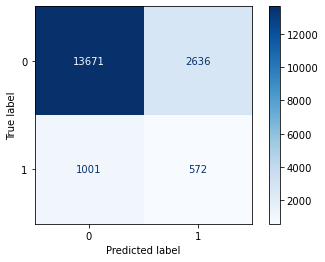

In [179]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

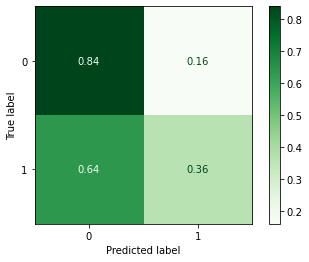

In [180]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', cmap='Greens')


In [181]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88     16307
           1       0.18      0.36      0.24      1573

    accuracy                           0.80     17880
   macro avg       0.56      0.60      0.56     17880
weighted avg       0.87      0.80      0.83     17880



Classification with the F1-optimizing threshold keeps a certain accuracy (80%). However, only 36% of all minority class instances are predicted as 1 which is not satisfying for our model purpose.

b) F2-optimizing threshold

In [285]:
# calculate probability estimates for class 1
y_prob = clf_opt.predict_proba(X_test)
y_prob_1 = y_prob[:,1]

#calculate predictions using custom discrimination threshold
y_pred = (y_prob_1 >= best_thresh_f2).astype(int)

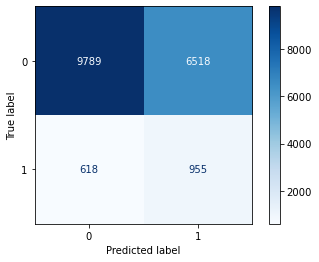

In [286]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

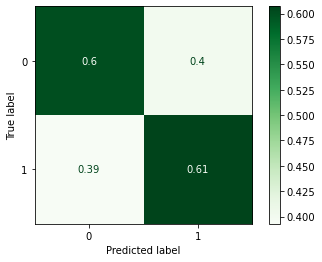

In [287]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', cmap='Greens')

In [288]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.60      0.73     16307
           1       0.13      0.61      0.21      1573

    accuracy                           0.60     17880
   macro avg       0.53      0.60      0.47     17880
weighted avg       0.87      0.60      0.69     17880



The classification with the F2-optimizing threshold is similar to the one resulting of the ROC-AUC optimization. 61% of all patients which wil be readmitted within 30 days are recognized beforehand.

### 3.1.6. Logistic Regression on Resampled Data
[Back to top](#top)

A different approach is the application of a unweighted logistic regression model on data which was balanced before using sampling techniques.
We will test this approach by applying our already built basic model on three differently generated datasets.  

#### Model Fitting and Evaluation

a) Randomly undersampled training data

In [191]:
clf.fit(X_train_rus, y_train_rus)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [193]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.65      0.77     16307
           1       0.13      0.56      0.21      1573

    accuracy                           0.64     17880
   macro avg       0.54      0.60      0.49     17880
weighted avg       0.87      0.64      0.72     17880



2. Randomly oversampled training data

In [194]:
clf.fit(X_train_ros, y_train_ros)

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     16307
           1       0.14      0.55      0.22      1573

    accuracy                           0.66     17880
   macro avg       0.54      0.61      0.50     17880
weighted avg       0.87      0.66      0.73     17880



3. Oversampled training data resulting from SMOTE

In [195]:
clf.fit(X_train_smote, y_train_smote)

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     16307
           1       0.16      0.02      0.04      1573

    accuracy                           0.90     17880
   macro avg       0.54      0.50      0.49     17880
weighted avg       0.85      0.90      0.87     17880



#### Conclusion

While the basic model shows terrible results when fitted on the SMOTE-generated dataset, the evaluation metrics of the models fitted on randomly over-/undersmapled datasets are comparable with the results we got in the previous analyses. 

### 3.1.7. Feature Importance: Logistic Regression Coefficients
[Back to top](#top)

When the input data was scaled, the coefficients of a linear regression model can be seen as a crude feature importance metric. (https://machinelearningmastery.com/calculate-feature-importance-with-python/)

In [301]:
# Retrieve coefficients from the logistic regression model
coef_base = clf['logisticregression'].coef_[0]

# Save as dataframe and sort by coefficient value
df_coef = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coef_balanced})
df_coef.sort_values(by='Coefficient', ascending=False).head(2)

,Feature,Coefficient
6,number_inpatient,4.142122
5,number_emergency,3.407906


In [295]:
# Retrieve coefficients from the logistic regression model
coef_opt = clf_opt['logisticregression'].coef_[0]

In [300]:
# Save as dataframe and sort by coefficient value

df_coef = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coef_opt})
df_coef.sort_values(by='Coefficient', ascending=False).head(2)

,Feature,Coefficient
6,number_inpatient,4.006076
5,number_emergency,2.262570


In [299]:
# Retrieve coefficients from the logistic regression model
coef_balanced = clf_balanced['logisticregression'].coef_[0]

# Save as dataframe and sort by coefficient value
df_coef = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coef_balanced})
df_coef.sort_values(by='Coefficient', ascending=False).head(2)

,Feature,Coefficient
6,number_inpatient,4.142122
5,number_emergency,3.407906


We observe that the number of hospital admissions (inpatient and emergency) in the year preceding the encounter are the most important influence factors for readmission from the perspective of the built logistic regression model. While the exact coefficient values differ in the varied models, these two features have always the highest values.

### 3.1.7. Conclusion
[Back to top](#top)

- Building the perfect model is not possible
- Recall is important for us but its improvement always go at the expese of accuracy and precision